<a href="https://colab.research.google.com/github/SHWETANK-SAURABH/eyeconic/blob/main/Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Token

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json from kaggle_account > your_profile > API section > Create new token
files.upload();

Saving kaggle.json to kaggle.json


## Download Dataset and Extract

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from kaggle
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
100% 1.62G/1.62G [00:21<00:00, 91.4MB/s]
100% 1.62G/1.62G [00:21<00:00, 82.5MB/s]


In [ ]:
from tqdm.notebook import tqdm
import zipfile

zip_file_path = 'ocular-disease-recognition-odir5k.zip'
extracted_dir = 'dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc='Extracting'):
        zip_ref.extract(file, extracted_dir)

print(f"Dataset extracted to {extracted_dir}")

Extracting:   0%|          | 0/14394 [00:00<?, ?it/s]

Dataset extracted to dataset


## Load Datasets and csv files

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import os

In [ ]:
df = pd.read_csv("dataset/full_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [ ]:
# Function to check if a given text contains the word "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

left_cataract[:10], right_cataract[:10]

(array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
        '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
        '465_left.jpg', '477_left.jpg'], dtype=object),
 array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
        '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
        '553_right.jpg', '560_right.jpg'], dtype=object))

In [ ]:
len(left_cataract), len(right_cataract)

(304, 290)

In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:10]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract), axis=0)
normal = np.concatenate((left_normal,right_normal), axis=0)

In [ ]:
len(cataract),len(normal)

(594, 500)

## PyTorch

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, TensorDataset, DataLoader

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.4.1+cu121
cuda


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, image_category, label, dataset_dir, image_size=224):
    self.image_category = image_category
    self.label = label
    self.dataset_dir = dataset_dir
    self.image_size = image_size
    self.data = self.create_dataset()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img, label = self.data[idx]
    return img, label

  def create_dataset(self):
    dataset = []
    dataset_label = []
    for img in tqdm(self.image_category):
      image_path = os.path.join(self.dataset_dir, img)
      try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (self.image_size, self.image_size))
      except:
        continue

      dataset.append([np.array(image), np.array(self.label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset_cataract = CustomDataset(image_category = cataract,
                                 label = 1,
                                 dataset_dir = "dataset/preprocessed_images/",
                                 image_size = 224)

dataset_normal = CustomDataset(normal, 0, "dataset/preprocessed_images/", 224)

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
dataset = ConcatDataset([dataset_cataract, dataset_normal])

print("Combined dataset length:", len(dataset))

Combined dataset length: 1088


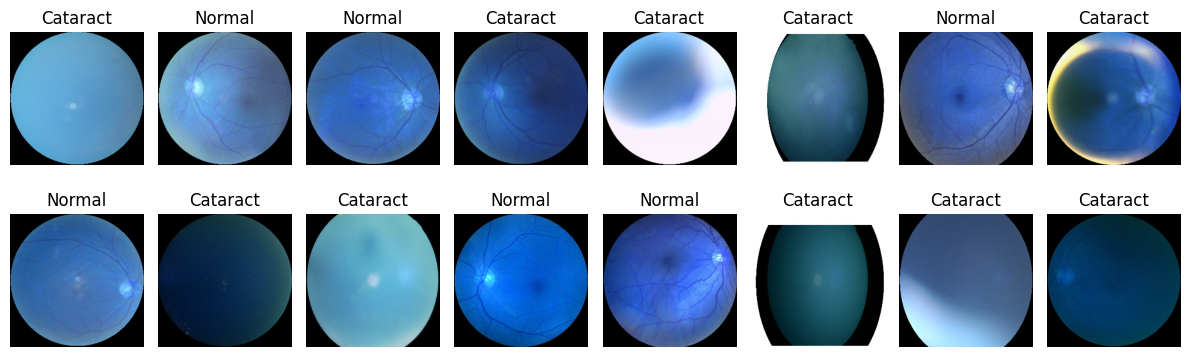

In [ ]:
plt.figure(figsize=(12, 4))
rows, cols = 2, 8
for i in range(1, rows*cols + 1):
  sample = random.choice(range(len(dataset)))
  image = dataset[sample][0]
  category = dataset[sample][1]

  label = "Normal" if category == 0 else "Cataract"

  plt.subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(label)
  plt.axis(False);
plt.tight_layout()

In [ ]:
dataset[0][0].shape

(224, 224, 3)

In [ ]:
X = np.array([i[0] for i in dataset]).reshape(-1, 224, 224, 3)
y = np.array([i[1] for i in dataset])

### Conversion of datas in arrays to tensor format

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X[0], y[:10]

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 tensor([1, 

## Tran and test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

len(X_train), len(X_test), y_train[:10]

(870, 218, tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1]))

In [ ]:
X_train.shape

torch.Size([870, 224, 224, 3])

In [ ]:
# Permute the color channel index to front
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [ ]:
# Turn datasets into batches
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)      # Shuffle false cuz already shuffled using sklearn->train_test_spilt

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(28, 7)

In [ ]:
# Checking shape of train_images and train_labels dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## TinyVGG BaseModel with added `Conv2d` Layers

In [ ]:
class CataractModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super(CataractModel, self).__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(hidden_units)  # Batch normalization for stabilization
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(2 * hidden_units)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(2 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(output_shape)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28 * output_shape, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout for regularization
        nn.Linear(512, output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)
    return x

In [ ]:
model = CataractModel(3, 10, 2).to(device)   # (3, 10, 2) -> (Color_channel, hidden_units, output_shape)
model, next(model.parameters()).device

(CataractModel(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(40, 2, kernel_size=(3, 3), stride=(1, 1), padding=

## Train and Test DataLoaders

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 23.0 MB/s eta 0:00:00


In [ ]:
# Import Accuracy
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = "binary",
                                 num_classes = 2).to(device)

In [ ]:
# Setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [ ]:
# Train and Test function
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0

  model.to(device)
  train_losses = []
  train_accuracies = []
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += torchmetrics_accuracy(y,
                                       y_pred.argmax(dim = 1)) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss.item())
  train_accuracies.append(train_acc.item())
  print(f'Train loss: {train_loss:.4f} ---- Train acc: {train_acc:.2f}%')
  return train_losses, train_accuracies

def test_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  test_losses = []
  test_accuracies = []

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += torchmetrics_accuracy(y,
                                        test_pred.argmax(dim = 1)) * 100
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f'Test loss: {test_loss:.4f} ---- Test acc: {test_acc:.2f}%')
  return test_losses, test_accuracies

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 15
train_losses_history = []
train_accuracies_history = []
test_losses_history = []
test_accuracies_history = []

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_losses, train_accuracies = train_step(model, train_dataloader, loss_fn, optimizer,
                                              torchmetrics_accuracy, device)
  test_losses, test_accuracies = test_step(model, test_dataloader, loss_fn, optimizer,
                                           torchmetrics_accuracy, device)
  # Calculate avg. loss and accuracy
  avg_train_loss = sum(train_losses) / len(train_losses)
  avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
  avg_test_loss = sum(test_losses) / len(test_losses)
  avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

  train_losses_history.append(avg_train_loss)
  train_accuracies_history.append(avg_train_accuracy)
  test_losses_history.append(avg_test_loss)
  test_accuracies_history.append(avg_test_accuracy)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.7234 ---- Train acc: 59.90%
Test loss: 0.6611 ---- Test acc: 62.40%
Epoch: 1
Train loss: 0.6210 ---- Train acc: 65.40%
Test loss: 0.6362 ---- Test acc: 62.16%
Epoch: 2
Train loss: 0.5984 ---- Train acc: 69.38%
Test loss: 0.6336 ---- Test acc: 68.82%
Epoch: 3
Train loss: 0.5099 ---- Train acc: 74.85%
Test loss: 0.5121 ---- Test acc: 77.51%
Epoch: 4
Train loss: 0.4164 ---- Train acc: 82.03%
Test loss: 0.4109 ---- Test acc: 79.84%
Epoch: 5
Train loss: 0.3128 ---- Train acc: 87.50%
Test loss: 0.2877 ---- Test acc: 89.22%
Epoch: 6
Train loss: 0.1973 ---- Train acc: 92.41%
Test loss: 0.2505 ---- Test acc: 87.53%
Epoch: 7
Train loss: 0.1648 ---- Train acc: 94.20%
Test loss: 0.2770 ---- Test acc: 88.53%
Epoch: 8
Train loss: 0.1542 ---- Train acc: 94.53%
Test loss: 0.2108 ---- Test acc: 90.76%
Epoch: 9
Train loss: 0.1026 ---- Train acc: 96.76%
Test loss: 0.2747 ---- Test acc: 90.76%
Epoch: 10
Train loss: 0.1012 ---- Train acc: 96.65%
Test loss: 0.2798 ---- Test acc: 90.56

## Plot loss curves and accuracy curves

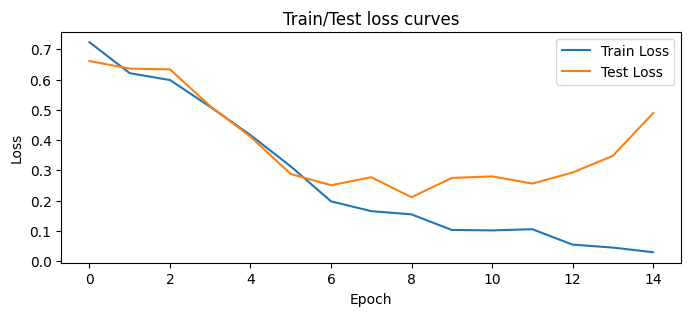

In [ ]:
# Plot loss curves
epoch = np.arange(0, len(train_losses_history))

plt.figure(figsize=(8, 3))
plt.plot(epoch, train_losses_history, label="Train Loss")
plt.plot(epoch, test_losses_history, label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

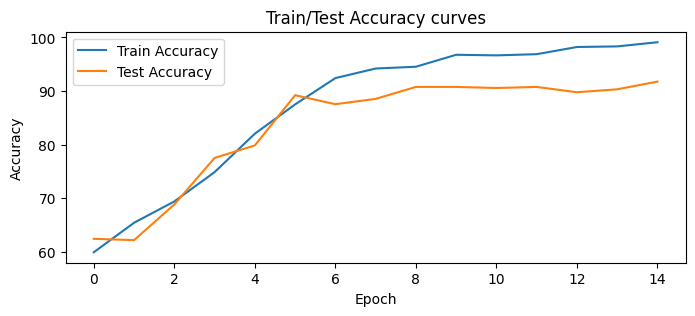

In [ ]:
# Plot accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(epoch, train_accuracies_history, label="Train Accuracy")
plt.plot(epoch, test_accuracies_history, label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

## Making Predictions

In [ ]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k = 20):
  test_samples.append(sample)
  test_labels.append(label)

In [ ]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [ ]:
# Make Predictions
pred_probs = make_predictions(model,
                              test_samples,
                              device)

# Convert prediction proabbilities to labels
pred_classes = pred_probs.argmax(dim = 1)
print(pred_classes, test_labels, sep = '\n')

tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])
[tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1)]


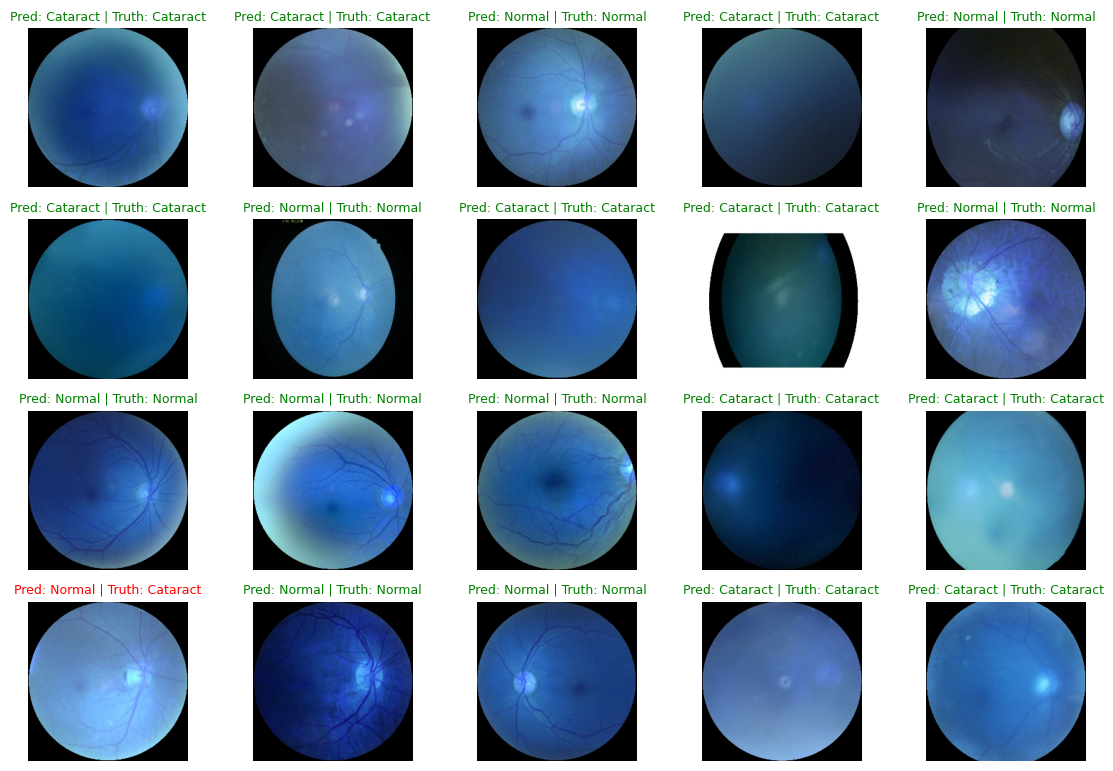

In [ ]:
# Plot predictions
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5
for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Cataract'])
  plt.subplot(nrows, ncols, i + 1)
  # Convert PyTorch tensor to NumPy array
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0  # Normalize pixel values to [0, 1]
  plt.imshow(normalized_sample)
  # print(normalized_sample.shape)
  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check equality between pred and truth and change color of title
  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False)
plt.show()


## Plot Confusion Matrix

In [ ]:
from tqdm.auto import tqdm

# Make prediciton with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader,
                   desc = "Making predictions...\t"):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1 )
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...	:   0%|          | 0/7 [00:00<?, ?it/s]

(tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1]), 218)

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


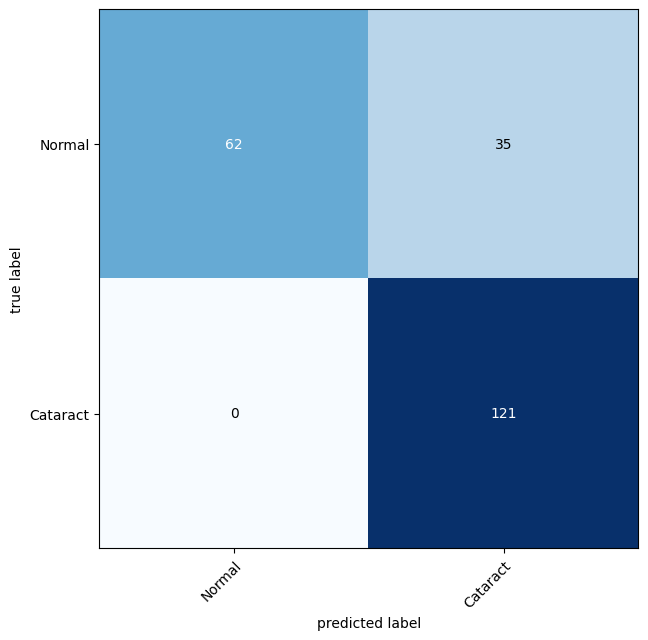

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_name), task = 'binary')
# print(y_pred_tensor, test_data.targets)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize = (10, 7)
);

## Saving and Loading Model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "EyeCataractDetectModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/EyeCataractDetectModel.pth


In [ ]:
loaded_model = CataractModel(3, 10, 2)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")
# loaded_model = loaded_model.to('cpu')     # For model to load in cpu and check inference

Loaded model:
CataractModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

<ipython-input-45-4172bf64ba94>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


## Make Prediciton using Saved Model

In [ ]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

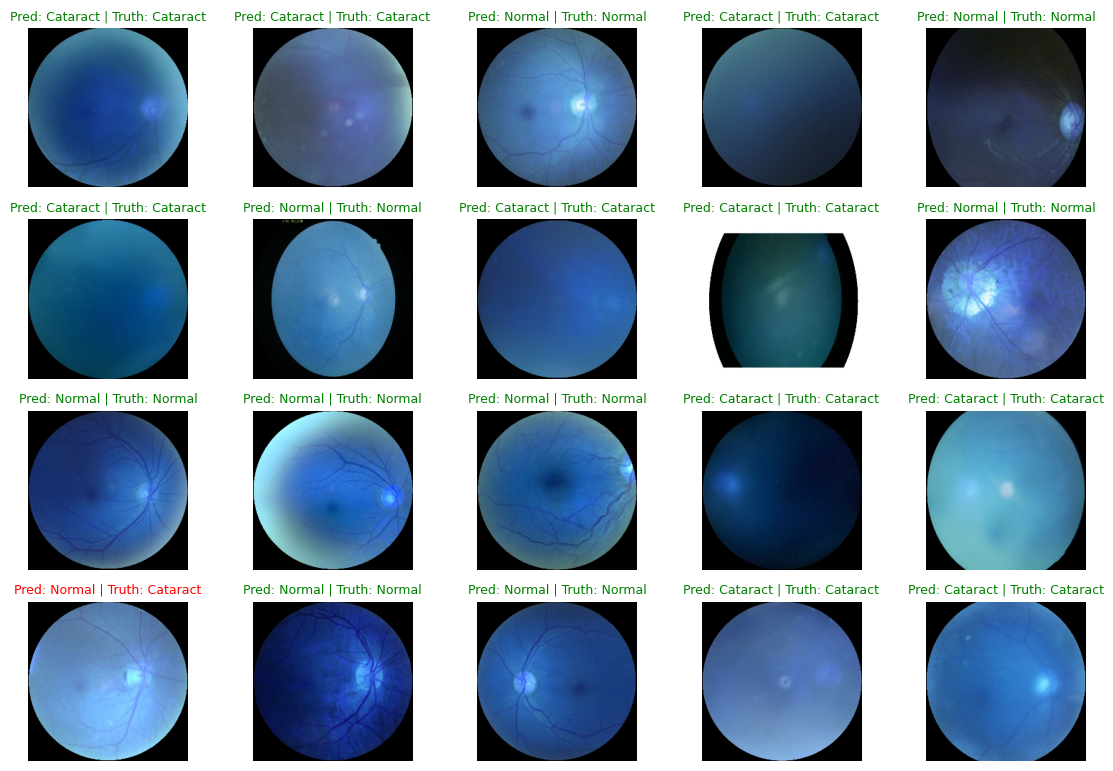

In [ ]:
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5

for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Cataract'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)
  # print(normalized_sample.shape)
  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);